In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.optimize import curve_fit

#turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#load ihmp runtime dataframe
ihmp_runtime = pd.read_csv("../results/ihmp-runtime-all.csv")
ihmp_runtime.drop(columns=['factor'], inplace=True)
ihmp_runtime

,index,method,n features,time (s),% features
0,0,Joint-RPCA,9562,1.223706,10.46
1,1,Joint-RPCA,10380,1.283670,11.35
2,2,Joint-RPCA,12018,1.837933,13.14
3,3,Joint-RPCA,13655,1.932425,14.94
4,4,Joint-RPCA,17748,3.457007,19.41
5,5,Joint-RPCA,21842,4.316535,23.89
6,6,Joint-RPCA,27428,6.031864,30.00
7,7,Joint-RPCA,32000,7.704982,35.00
8,8,Joint-RPCA,36571,9.098438,40.00
9,9,Joint-RPCA,91429,29.136795,100.00


In [3]:
#fit exponential curve to MMvec datapoints
def exponential_curve(x, a, b, c):
    return a * np.exp(b * x/1000) + c

popt, pcov = curve_fit(exponential_curve, ihmp_runtime['n features'][10:], 
                       ihmp_runtime['time (s)'][10:])
#estimated params
popt

array([ 1.26268544e+03,  2.15452267e-01, -1.05007216e+04])

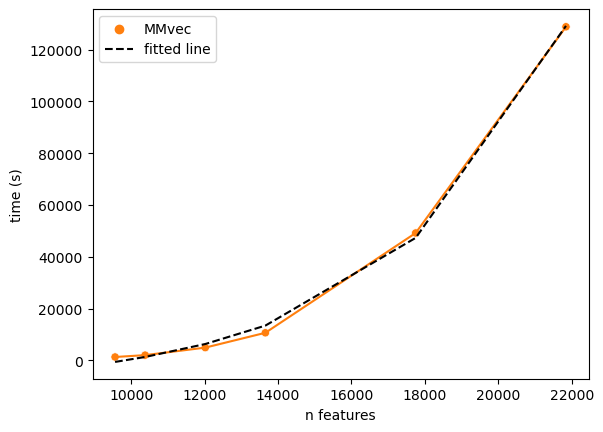

In [4]:
ihmp_mmvec = ihmp_runtime[ihmp_runtime['method'] == 'MMvec']

xaxis = 'n features'

sns.scatterplot(data=ihmp_mmvec, x=xaxis, y='time (s)', 
                hue='method', style='method', palette={'MMvec':'tab:orange'})
plt.plot(ihmp_mmvec[xaxis], ihmp_mmvec['time (s)'], 
         'tab:orange', label=None)
plt.plot(ihmp_mmvec[xaxis], 
         exponential_curve(ihmp_mmvec[xaxis], *popt), 'k--',
         label='fitted line')
plt.xlabel(xaxis)
plt.ylabel('time (s)')
plt.legend()
plt.show()

In [5]:
## add additional data points for MMvec based on fitted curve
p_features = [30.0, 35.0, 40.0]
n_features = [int(0.01 * p * 91429.00) for p in p_features]
est_time = exponential_curve(np.array(n_features), *popt)

extra_df = pd.DataFrame({'method':'MMvec', 'time (s)':est_time,
                         'n features':n_features, '% features':p_features})
extra_df['index'] = [6, 7, 8]

In [6]:
ihmp_runtime_all = ihmp_runtime.copy()
ihmp_runtime_all = pd.concat([ihmp_runtime_all, extra_df], ignore_index=True)

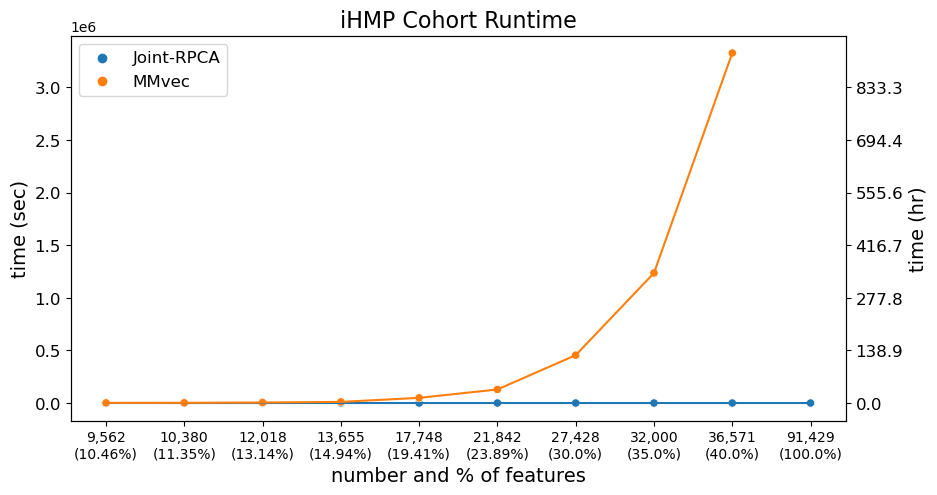

In [7]:
#estimate additional runtimes for MMvec using runtime
plt.figure(figsize=(10,5))
sns.scatterplot(data=ihmp_runtime_all, x='index', y='time (s)', 
                hue='method', palette={'Joint-RPCA':'tab:blue',
                                       'MMvec':'tab:orange'})
sns.lineplot(data=ihmp_runtime_all, x='index', y='time (s)', 
                hue='method', palette={'Joint-RPCA':'tab:blue',
                                       'MMvec':'tab:orange'})
#log y axis
#plt.yscale('log')
#increase font size
plt.ylabel('time (sec)', fontsize=14)
plt.yticks(fontsize=12)

#keep only half of the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], fontsize=12)

#get yticks
y_lim1 = plt.gca().get_ylim()
y_ticks = plt.gca().get_yticks()

#change xticks labels
all_p_features = sorted(list(ihmp_runtime_all['% features'].unique()))
all_n_features = sorted(list(ihmp_runtime_all['n features'].unique()))
x_labels = ['{:,}\n({}%)'.format(round(n), p) for p, n in zip(all_p_features, 
                                                              all_n_features)]
plt.xticks(list(range(0,10)), x_labels, fontsize=10)
plt.xlabel('number and % of features', fontsize=14)

#add second y axis with minutes instead of seconds
plt.twinx()
time_in_hr = [round(t / 3600, 1) for t in y_ticks]
plt.yticks(y_ticks, labels=time_in_hr, fontsize=12)
plt.ylabel('time (hr)', fontsize=14)
plt.ylim(y_lim1)  # Match the y-axis limits
plt.title('iHMP Cohort Runtime', fontsize=16)

plt.show()

## UC Cohort

In [8]:
#load joint-rpca runtime dataframe
uc_joint_rpca_runtime = pd.read_csv("../results/uc-joint-rpca-runtime.csv", index_col=0)
uc_joint_rpca_runtime.reset_index(inplace=True)
uc_joint_rpca_runtime

,index,time (s),% features,n features,method
0,0,4.598135,10.46,11880,Joint-RPCA
1,1,4.730030,11.35,12890,Joint-RPCA
2,2,5.828597,13.14,14923,Joint-RPCA
3,3,6.154361,14.94,16968,Joint-RPCA
4,4,8.300842,19.41,22045,Joint-RPCA
5,5,9.971474,23.89,27133,Joint-RPCA
6,6,13.201322,30.00,34072,Joint-RPCA
7,7,16.923151,35.00,39751,Joint-RPCA
8,8,17.198471,40.00,45430,Joint-RPCA
9,9,67.660998,100.00,113576,Joint-RPCA


### Predict runtime for MMvec

In [9]:
## create df for cohort two
p_features = sorted(uc_joint_rpca_runtime['% features'].unique())[:-1]
n_features = sorted(uc_joint_rpca_runtime['n features'].unique())[:-1]
est_time_uc = exponential_curve(np.array(n_features), *popt)

uc_mmvec_runtime = pd.DataFrame({'method':'MMvec', 'time (s)': est_time_uc,
                              'n features': n_features, '% features': p_features})
uc_mmvec_runtime.sort_values(by='n features', inplace=True)
uc_mmvec_runtime.reset_index(drop=False, inplace=True)
uc_mmvec_runtime

,index,method,time (s),n features,% features
0,0,MMvec,5.826172e+03,11880,10.46
1,1,MMvec,9.795210e+03,12890,11.35
2,2,MMvec,2.095041e+04,14923,13.14
3,3,MMvec,3.836298e+04,16968,14.94
4,4,MMvec,1.353941e+05,22045,19.41
5,5,MMvec,4.261384e+05,27133,23.89
6,6,MMvec,1.936666e+06,34072,30.00
7,7,MMvec,6.608395e+06,39751,35.00
8,8,MMvec,2.248875e+07,45430,40.00


In [10]:
#concat all dataframes
uc_all_runtime = pd.concat([uc_joint_rpca_runtime, uc_mmvec_runtime], ignore_index=True)
uc_all_runtime
#all_runtime = pd.concat([ihmp_runtime_all, uc_all_runtime], ignore_index=True)

,index,time (s),% features,n features,method
0,0,4.598135e+00,10.46,11880,Joint-RPCA
1,1,4.730030e+00,11.35,12890,Joint-RPCA
2,2,5.828597e+00,13.14,14923,Joint-RPCA
3,3,6.154361e+00,14.94,16968,Joint-RPCA
4,4,8.300842e+00,19.41,22045,Joint-RPCA
5,5,9.971474e+00,23.89,27133,Joint-RPCA
6,6,1.320132e+01,30.00,34072,Joint-RPCA
7,7,1.692315e+01,35.00,39751,Joint-RPCA
8,8,1.719847e+01,40.00,45430,Joint-RPCA
9,9,6.766100e+01,100.00,113576,Joint-RPCA


In [11]:
ihmp_joint = ihmp_runtime_all[ihmp_runtime_all['method'] == 'Joint-RPCA']
uc_joint = uc_all_runtime[uc_all_runtime['method'] == 'Joint-RPCA']
ihmp_mmvec = ihmp_runtime_all[ihmp_runtime_all['method'] == 'MMvec']
uc_mmvec = uc_all_runtime[uc_all_runtime['method'] == 'MMvec']
ihmp_mmvec.reset_index(drop=True, inplace=True)
uc_mmvec.reset_index(drop=True, inplace=True)

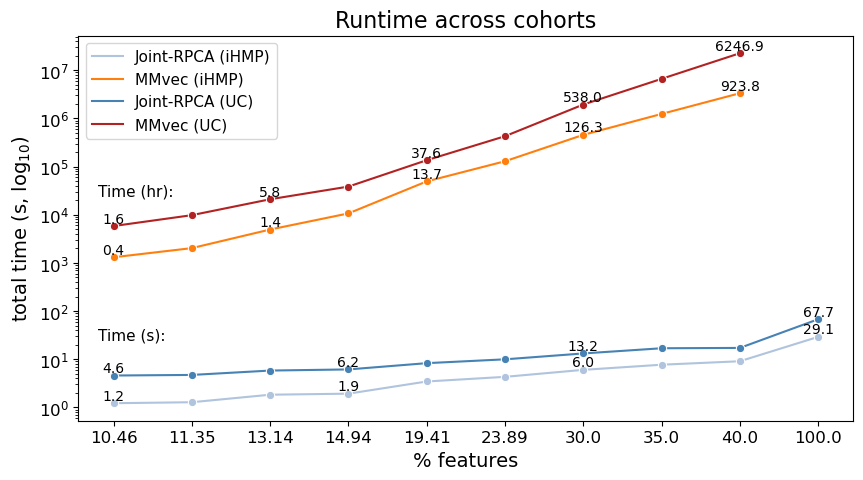

In [14]:
#estimate additional runtimes for MMvec using runtime
plt.figure(figsize=(10,5))

ihmp_palette = {'Joint-RPCA':'lightsteelblue', 'MMvec':'tab:orange'}
uc_palette = {'Joint-RPCA':'steelblue', 'MMvec':'firebrick'}

sns.lineplot(data=ihmp_runtime_all, x='index', y='time (s)', 
             hue='method', palette=ihmp_palette, marker="o")

sns.lineplot(data=uc_all_runtime, x='index', y='time (s)', 
             hue='method', palette=uc_palette, marker="o")
#log y axis
plt.yscale('log')
#increase font size
plt.ylabel('total time (s, log$_{10}$)', fontsize=14)
plt.yticks(fontsize=12)

#keep only half of the legend
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Joint-RPCA (iHMP)', 'MMvec (iHMP)', 
          'Joint-RPCA (UC)', 'MMvec (UC)']
plt.legend(handles[:4], labels, fontsize=11)

#get yticks
y_lim1 = plt.gca().get_ylim()
y_ticks = plt.gca().get_yticks()

#change xticks labels
all_p_features = sorted(list(ihmp_runtime_all['% features'].unique()))
plt.xticks(list(range(0,10)), all_p_features, fontsize=12)
plt.xlabel('% features', fontsize=14)

#add text to every other point to show the time in seconds
plt.text(-0.2, 25000, "Time (hr):", ha='left', fontsize=11)
for i, p in enumerate(all_p_features):
    if i % 3 == 0:
        #joint-rpca
        txt_ihmp_joint = ihmp_joint.loc[i, 'time (s)']
        plt.text(i, txt_ihmp_joint, round(txt_ihmp_joint, 1), 
                 fontsize=10, ha='center', va='bottom')
        
        txt_uc_joint = uc_joint.loc[i, 'time (s)']
        plt.text(i, txt_uc_joint, round(txt_uc_joint, 1), 
                 fontsize=10, ha='center', va='bottom')

plt.text(-0.2, 25, "Time (s):", ha='left', fontsize=11)   
for i, p in enumerate(ihmp_mmvec['% features'].unique()):
    if i % 2 == 0:
        #MMvec text
        txt_ihmp_mmvec = ihmp_mmvec.loc[i, 'time (s)']
        plt.text(i, txt_ihmp_mmvec, round(txt_ihmp_mmvec/3600, 1), 
                 fontsize=10, ha='center', va='bottom')
        
        txt_uc_mmvec = uc_mmvec.loc[i, 'time (s)']
        plt.text(i, txt_uc_mmvec, round(txt_uc_mmvec/3600, 1), 
                 fontsize=10, ha='center', va='bottom')

plt.title('Runtime across cohorts', fontsize=16)
plt.show()